### Import Required Libraries

In [3]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, Bidirectional, RepeatVector, TimeDistributed
from keras.preprocessing.text import Tokenizer
from keras.callbacks import ModelCheckpoint
from keras.preprocessing.sequence import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
% matplotlib inline
pd.set_option('display.max_colwidth', 200)

Using TensorFlow backend.
UsageError: Line magic function `%` not found.


### Read Data

Our data is a text file of English-German sentence pairs. First we will read the file using the function defined below.

In [4]:
# function to read raw text file
def read_text(filename):
    # open the file
    file = open(filename, mode='rt', encoding='utf-8')
    # read all text
    text = file.read()
    file.close()
    return text

Now let's define a function to split the text into English-German pairs separated by '\n' and then split these pairs into English sentences and German sentences.

In [5]:
# split a text into sentences
def to_lines(text):
    sents = text.strip().split('\n')
    sents = [i.split('\t') for i in sents]
    return sents

__Download the data from [here.](http://www.manythings.org/anki/deu-eng.zip)__ and extract "deu.txt" in your working directory.

In [6]:
data = read_text("deu-eng\deu_modif.txt")
deu_eng = to_lines(data)
deu_eng = array(deu_eng)

The actual data contains over 150,000 sentence-pairs. However, we will use the first 50,000 sentence pairs only to reduce the training time of the model. You can change this number as per you system computation power.

In [7]:
deu_eng = deu_eng[:50000,:]

### Text Pre-Processing

#### Text Cleaning

Let's take a look at our data, then we will decide which pre-processing steps to adopt.

In [8]:
deu_eng

array([['Hi.', 'Hallo!'],
       ['Hi.', 'Grüß Gott!'],
       ['Run!', 'Lauf!'],
       ...,
       ['I wholeheartedly agree.', 'Ich stimme rückhaltlos zu.'],
       ['I will always love you.', 'Ich werde dich immer lieben.'],
       ['I will be back by nine.', 'Um neun bin ich wieder zurück.']],
      dtype='<U537')

We will get rid of the punctuation marks, and then convert the text to lower case.

In [9]:
# Remove punctuation
deu_eng[:,0] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,0]]
deu_eng[:,1] = [s.translate(str.maketrans('', '', string.punctuation)) for s in deu_eng[:,1]]

In [10]:
deu_eng

array([['Hi', 'Hallo'],
       ['Hi', 'Grüß Gott'],
       ['Run', 'Lauf'],
       ...,
       ['I wholeheartedly agree', 'Ich stimme rückhaltlos zu'],
       ['I will always love you', 'Ich werde dich immer lieben'],
       ['I will be back by nine', 'Um neun bin ich wieder zurück']],
      dtype='<U537')

In [11]:
# convert to lowercase
for i in range(len(deu_eng)):
    deu_eng[i,0] = deu_eng[i,0].lower()
    
    deu_eng[i,1] = deu_eng[i,1].lower()

In [12]:
deu_eng

array([['hi', 'hallo'],
       ['hi', 'grüß gott'],
       ['run', 'lauf'],
       ...,
       ['i wholeheartedly agree', 'ich stimme rückhaltlos zu'],
       ['i will always love you', 'ich werde dich immer lieben'],
       ['i will be back by nine', 'um neun bin ich wieder zurück']],
      dtype='<U537')

#### Text to Sequence Conversion

To feed our data in a Seq2Seq model, we will have to convert both the input and the output sentences into integer sequences of fixed length. Before that, let's visualise the length of the sentences. We will capture the lengths of all the sentences in two separate lists for English and German, respectively.

In [13]:
# empty lists
eng_l = []
deu_l = []

# populate the lists with sentence lengths
for i in deu_eng[:,0]:
    eng_l.append(len(i.split()))

for i in deu_eng[:,1]:
    deu_l.append(len(i.split()))

In [18]:
length_df = pd.DataFrame({'eng':eng_l, 'deu':deu_l})
print(length_df)
print(max(length_df.eng))
print(max(length_df.deu))

       eng  deu
0        1    1
1        1    2
2        1    1
3        1    1
4        1    1
...    ...  ...
49995    3    6
49996    3    6
49997    3    4
49998    5    5
49999    6    6

[50000 rows x 2 columns]
7
15


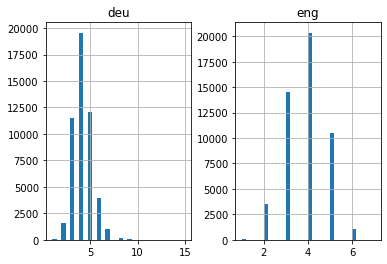

In [15]:
length_df.hist(bins = 30)
plt.show()

The maximum length of the German sentences is 11 and that of the English phrases is 8.

Let's vectorize our text data by using Keras's Tokenizer() class. It will turn our sentences into sequences of integers. Then we will pad those sequences with zeros to make all the sequences of same length.

In [19]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

In [20]:
# prepare english tokenizer
eng_tokenizer = tokenization(deu_eng[:, 0])
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 8
print('English Vocabulary Size: %d' % eng_vocab_size)

English Vocabulary Size: 6361


In [21]:
# prepare Deutch tokenizer
deu_tokenizer = tokenization(deu_eng[:, 1])
deu_vocab_size = len(deu_tokenizer.word_index) + 1

deu_length = 8
print('Deutch Vocabulary Size: %d' % deu_vocab_size)

Deutch Vocabulary Size: 10597


In [35]:
print(deu_tokenizer.word_counts)

OrderedDict([('hallo', 35), ('grüß', 3), ('gott', 29), ('lauf', 8), ('potzdonner', 2), ('donnerwetter', 1), ('feuer', 24), ('hilfe', 129), ('zu', 2081), ('hülf', 1), ('stopp', 2), ('warte', 44), ('mach', 201), ('weiter', 115), ('ich', 11796), ('rannte', 48), ('verstehe', 51), ('aha', 1), ('probiere', 6), ('es', 4120), ('hab', 46), ('gewonnen', 69), ('habe', 2136), ('lächeln', 20), ('zum', 165), ('wohl', 51), ('iss', 22), ('auf', 1143), ('keine', 395), ('bewegung', 5), ('stehenbleiben', 2), ('kapiert', 2), ('verstanden', 29), ('einverstanden', 38), ('er', 2838), ('lief', 29), ('mit', 709), ('drück', 7), ('mich', 1639), ('nimm', 91), ('in', 883), ('den', 739), ('arm', 54), ('umarme', 2), ('fiel', 32), ('hin', 100), ('stürzte', 6), ('bin', 1798), ('hingefallen', 1), ('gestürzt', 1), ('weiß', 445), ('gelogen', 32), ('verloren', 145), ('bezahlt', 39), ('zahlte', 3), ('sang', 20), ('schwimme', 9), ('19', 3), ('jahre', 28), ('alt', 123), ('mir', 1823), ('gehts', 27), ('gut', 650), ('geht', 37

Given below is a function to prepare the sequences. It will also perform sequence padding to a maximum sentence length as mentioned above. 

In [22]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    # integer encode sequences
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    print(seq)
    print(len(seq))
    return seq

<bound method Tokenizer.texts_to_sequences of <keras_preprocessing.text.Tokenizer object at 0x000001D5AD17AA08>>


### Model Building

We will now split the data into train and test set for model training and evaluation, respectively.

In [23]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(deu_eng, test_size=0.2, random_state = 12)

It's time to encode the sentences. We will encode German sentences as the input sequences and English sentences as the target sequences. It will be done for both train and test datasets.

In [24]:
# prepare training data
trainX = encode_sequences(deu_tokenizer, deu_length, train[:, 1])
trainY = encode_sequences(eng_tokenizer, eng_length, train[:, 0])

[[ 203  102   48 ...    0    0    0]
 [   1   20  180 ...    0    0    0]
 [  97  784 2968 ...    0    0    0]
 ...
 [   1  202 7407 ...    0    0    0]
 [  17  274  659 ...    0    0    0]
 [   9   10   36 ...    0    0    0]]
[[  11    3   23 ...    0    0    0]
 [   2   13  188 ...    0    0    0]
 [  56 1295  525 ...    0    0    0]
 ...
 [   2  283 3034 ...    0    0    0]
 [   8  614    4 ...    0    0    0]
 [  10 1723    5 ...    0    0    0]]


In [27]:
print(trainX.shape)
print(trainY.shape)

(40000, 8)
(40000, 8)


In [25]:
# prepare validation data
testX = encode_sequences(deu_tokenizer, deu_length, test[:, 1])
testY = encode_sequences(eng_tokenizer, eng_length, test[:, 0])

[[ 21 566 500 ...   0   0   0]
 [  1 346  18 ...   0   0   0]
 [  7 195  15 ...   0   0   0]
 ...
 [  2   3  12 ...   0   0   0]
 [ 57  33   8 ...   0   0   0]
 [ 29  67  11 ...   0   0   0]]
[[  3  57   7 ...   0   0   0]
 [  2 157 162 ...   0   0   0]
 [ 12 356   1 ...   0   0   0]
 ...
 [  1   4   5 ...   0   0   0]
 [ 54 175   3 ...   0   0   0]
 [ 39  11  20 ...   0   0   0]]


In [28]:
print(testX.shape)
print(testY.shape)

(10000, 8)
(10000, 8)


Now comes the exciting part! Let us define our Seq2Seq model architecture. We are using an Embedding layer and an LSTM layer as our encoder and another LSTM layer followed by a Dense layer as the decoder.  

In [29]:
# build NMT model
def build_model(in_vocab, out_vocab, in_timesteps, out_timesteps, units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))    
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

Details about the RepeatVector :  https://campus.datacamp.com/courses/machine-translation-in-python/implementing-an-encoder-decoder-model-with-keras?ex=6

We are using RMSprop optimizer in this model as it is usually a good choice for recurrent neural networks.

In [29]:
print(deu_vocab_size)
print(eng_vocab_size)
print(deu_length)
print(eng_length)

10597
6361
8
8


In [30]:
model = build_model(deu_vocab_size, eng_vocab_size, deu_length, eng_length, 512)
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

Please note that we have used __'sparse_categorical_crossentropy'__ as the loss function because it allows us to use the target sequence as it is instead of one hot encoded format. One hot encoding the target sequences with such a huge vocabulary might consume our system's entire memory.

It seems we are all set to start training our model. We will train it for 30 epochs and with a batch size of 512. You may change and play these hyperparameters. We will also be using __ModelCheckpoint()__ to save the best model with lowest validation loss. I personally prefer this method over early stopping.

In [31]:
filename = 'model.h1.24_jan_19'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1), 
          epochs=30, batch_size=512, 
          validation_split = 0.2,
          callbacks=[checkpoint], verbose=1)

C:\Users\ana_2\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


Train on 32000 samples, validate on 8000 samples
Epoch 1/30
32000/32000 [==============================] - 270s 8ms/step - loss: 3.4852 - val_loss: 2.9231

Epoch 00001: val_loss improved from inf to 2.92312, saving model to model.h1.24_jan_19
Epoch 2/30
32000/32000 [==============================] - 256s 8ms/step - loss: 2.8514 - val_loss: 2.8277

Epoch 00002: val_loss improved from 2.92312 to 2.82767, saving model to model.h1.24_jan_19
Epoch 3/30
32000/32000 [==============================] - 38819s 1s/step - loss: 2.6708 - val_loss: 2.6531

Epoch 00003: val_loss improved from 2.82767 to 2.65306, saving model to model.h1.24_jan_19
Epoch 4/30
32000/32000 [==============================] - 172s 5ms/step - loss: 2.4866 - val_loss: 2.5386

Epoch 00004: val_loss improved from 2.65306 to 2.53858, saving model to model.h1.24_jan_19
Epoch 5/30
32000/32000 [==============================] - 165s 5ms/step - loss: 2.3500 - val_loss: 2.4082

Epoch 00005: val_loss improved from 2.53858 to 2.40816,

Let's compare the training loss and the validation loss.

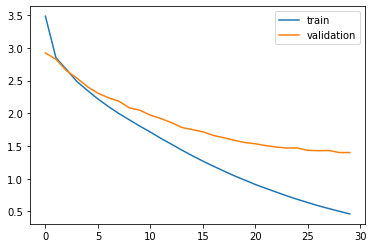

In [32]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])
plt.show()

### Make Predictions

Let's load the saved model to make predictions.

In [33]:
model = load_model('model.h1.24_jan_19')
preds = model.predict_classes(testX.reshape((testX.shape[0],testX.shape[1])))

C:\Users\ana_2\Anaconda3\lib\site-packages\tensorflow_core\python\framework\indexed_slices.py:424: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [34]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [35]:
# convert predictions into text (English)
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], eng_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], eng_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
             
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t)            
        
    preds_text.append(' '.join(temp))

In [36]:
pred_df = pd.DataFrame({'actual' : test[:,0], 'predicted' : preds_text})

In [37]:
pd.set_option('display.max_colwidth', 200)

In [38]:
pred_df.head(15)

,actual,predicted
0,you need to wake up,you should to awake
1,i feel old,i feel old
2,im sorry tom,sorry it
3,hide the money,is money
4,is someone calling me,help me
5,you should work hard,you should work hard
6,tom has a big problem,tom has a small nose
7,he lives with his mom,he lives her old
8,whats toms job,whats toms job
9,i dont want to drive,i dont want to


In [39]:
pred_df.tail(15)

,actual,predicted
9985,do you need a ride,can i sit you
9986,it is very small,its very small
9987,we can handle that,we can count it
9988,nobody believes you,no one believes you
9989,tom never changes,tom never laughs
9990,i just emailed you,i just found him tom
9991,tom is so stupid,tom is so stupid
9992,i found tom,i found tom
9993,i met mary yesterday,i saw her yesterday
9994,try and stop me,try to me


In [37]:
pred_df.tail(15)

,actual,predicted
9985,tom knew the risks,tom was all of
9986,what does she do,what does you do
9987,she still loved him,she still him sing
9988,i want to be careful,i want to be boston
9989,im here arent i,im here
9990,youre a hypocrite,youre a hypocrite
9991,i gave you a book,i gave you a book
9992,lets do it,do it
9993,i broke my leg skiing,i broke my
9994,i was victorious,i was been asleep


In [40]:
pred_df.sample(15)

,actual,predicted
3769,are you overweight,are you
6744,i didnt see a ghost,i didnt not a
1956,the price is going up,the wind is come
6860,tom isnt a painter,tom isnt a
1201,am i boring you,am i boring you
7790,its getting late,its is late
8263,its worthless junk,its not no
6170,heres some water,heres a just
1436,mary sings soprano,mary is at a
5354,i have a truck,i have a twin
